# Intel Scene Classification Challenge

The goal is to classify images of size 150x150 into 6 disctinct categories : 'buildings', 'forest', 'glacier', 'mountain', 'sea' and 'street'.

The data was provided by Intel.

## Importing libraries

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from IPython.display import SVG

In [ ]:
label_to_class={
    0 : 'buildings',
    1 : 'forest',
    2 : 'glacier',
    3 : 'mountain',
    4 : 'sea',
    5 : 'street'
}

We will represent some arbitrary images and their labels, since we shuffled the dataset, we can simply show the 20 first images.

## Preparation of the data generators

In [ ]:
train_data_path = 'seg_train'
test_data_path = 'seg_test'

size=(150,150)
epochs = 30
batch_size = 32
num_of_train_samples = 14000
num_of_test_samples = 3000

#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Creating the model

**First, let's try a simple model with 3 convolutional layers and 2 fully connected layers**

In [ ]:
num_classes = 6

model = Sequential()

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))

#The batch normalization allows the model to converge much faster
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(num_classes,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)      

## Training the model

In [ ]:
training = model.fit_generator(train_generator,
                                      steps_per_epoch=num_of_train_samples // batch_size,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=num_of_test_samples // batch_size)


Epoch 1/30
437/437 [==============================] - 793s 2s/step - loss: 1.2258 - accuracy: 0.5183 - val_loss: 2.0020 - val_accuracy: 0.4543
Epoch 2/30
437/437 [==============================] - 793s 2s/step - loss: 1.0077 - accuracy: 0.6180 - val_loss: 0.6091 - val_accuracy: 0.7109
Epoch 3/30
437/437 [==============================] - 789s 2s/step - loss: 0.9291 - accuracy: 0.6497 - val_loss: 0.7877 - val_accuracy: 0.7116
Epoch 4/30
437/437 [==============================] - 784s 2s/step - loss: 0.8610 - accuracy: 0.6772 - val_loss: 0.5990 - val_accuracy: 0.7358
Epoch 5/30
437/437 [==============================] - 783s 2s/step - loss: 0.8178 - accuracy: 0.6936 - val_loss: 0.8550 - val_accuracy: 0.7429
Epoch 6/30
437/437 [==============================] - 793s 2s/step - loss: 0.7818 - accuracy: 0.7124 - val_loss: 0.5327 - val_accuracy: 0.7931
Epoch 7/30
437/437 [==============================] - 789s 2s/step - loss: 0.7552 - accuracy: 0.7243 - val_loss: 0.6695 - val_accuracy: 0.796

## Analysis of the predictions

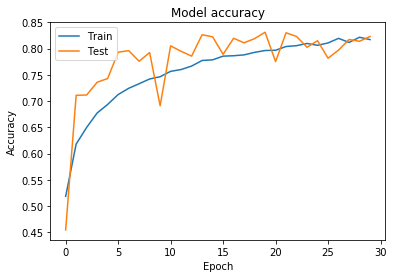

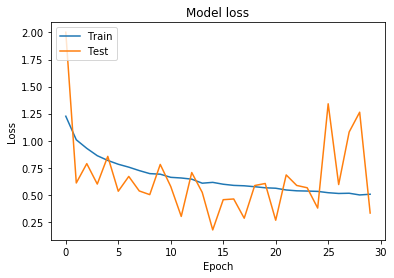

In [ ]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**The model does not seem to overfit, it has a better accuracy on the validation set because the data augmentation creates images more difficult to classify.**

**The confusion matrix will show us the most frequent mistakes made by this classifier.**

In [ ]:
validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)

Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


c=0
for i in range(len(validation_generator.classes)):
  if validation_generator.classes[i]==y_pred[i]:
    c+=1
    
print("Accuracy")
print(c/len(y_pred))

conf_mx=confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')

print(conf_mx)

Found 3000 images belonging to 6 classes.
Accuracy
0.8216666666666667
Confusion Matrix
[[388   8   3   6   5  27]
 [  4 465   1   3   0   1]
 [ 11   8 435  64  32   3]
 [  9   6  68 394  48   0]
 [ 18  10  22  18 435   7]
 [107  29   5   5   7 348]]


**The results are promising considering the complexity of the task.**

In [ ]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

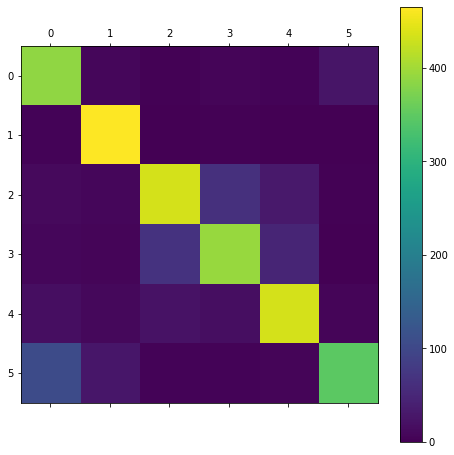

In [ ]:
plot_confusion_matrix(conf_mx)

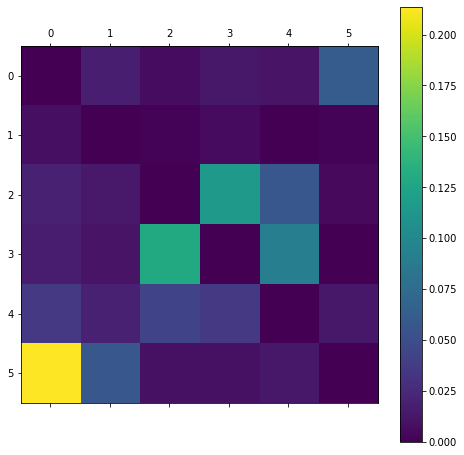

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx)

This matrix shows us that the most common confusions are between **streets and buildings**, there are also confusions between **glaciers and mountains**.

**Let's look at some badly classified images**

In [ ]:
#Shows errors of prediction between two classes, limited to n images
#Not symetric, will show images from class cl1 predicted as images from class cl2
def errors(predictions, cl1, cl2, n):
  _,ax = plt.subplots(n//5,5, figsize = (15,15)) 
  c=0
  for k in range(len(validation_generator.classes)):
    if validation_generator.classes[k]==cl1 and predictions[k]==cl2 and c<n:
      path = validation_generator.filepaths[k]
      image = cv2.imread(path)
      image = cv2.resize(image,size)
      i=c//5
      j=c%5
      ax[i,j].imshow(image)
      ax[i,j].set_title('predicted : '+label_to_class[cl2])
      ax[i,j].axis('off')
      c+=1

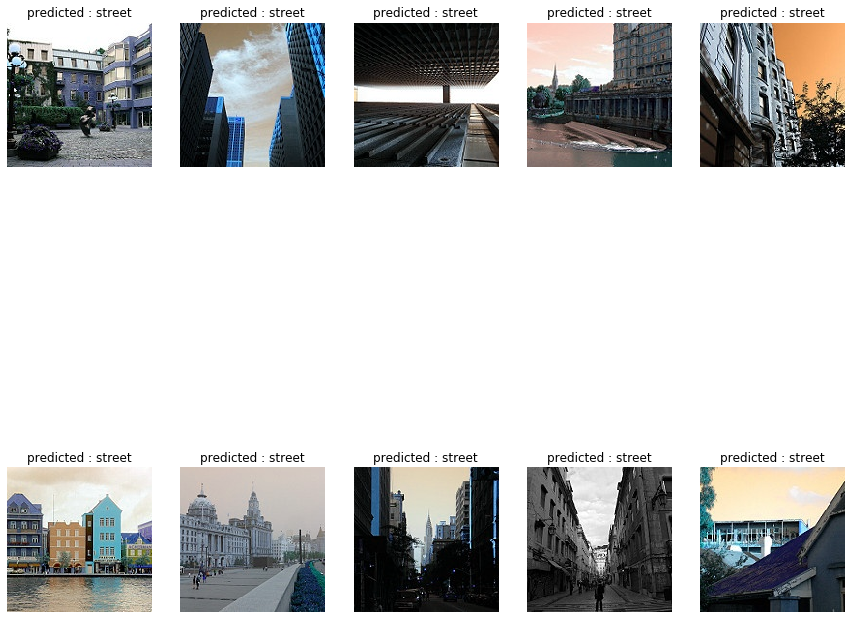

In [ ]:
#Images of buildings classified as streets
errors(y_pred,0,5,10)

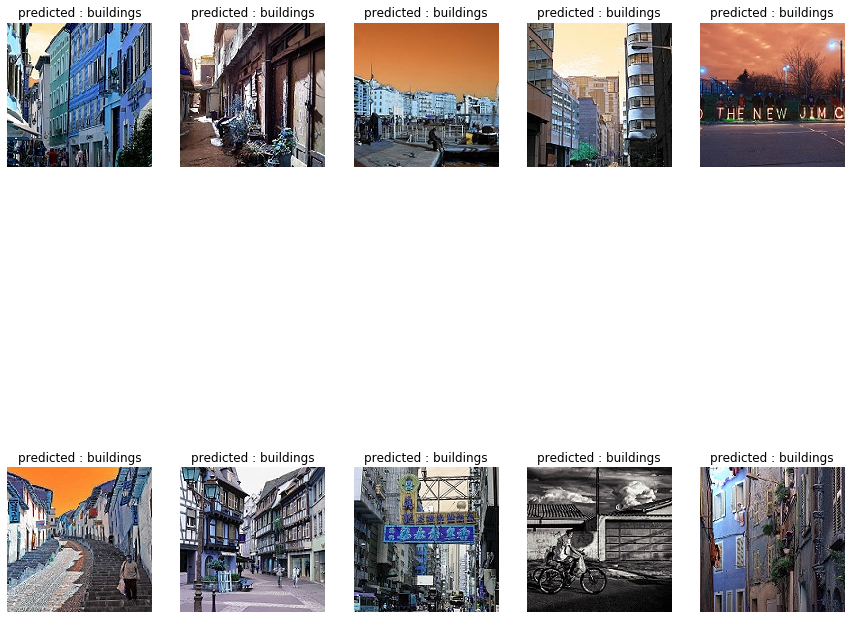

In [ ]:
#Images of streets classified as buildings
errors(y_pred,5,0,10)

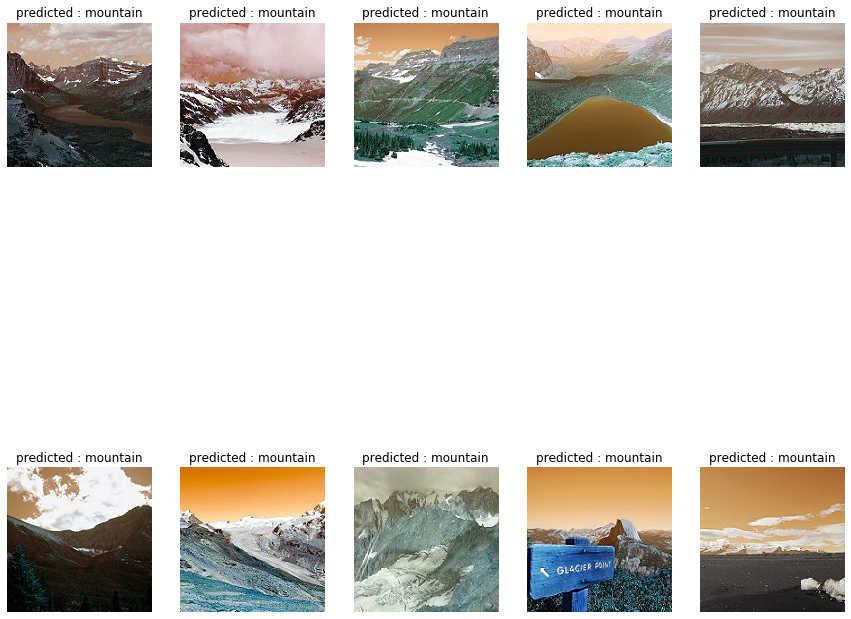

In [ ]:
#Images of glaciers classified as mountains
errors(y_pred,2,3,10)

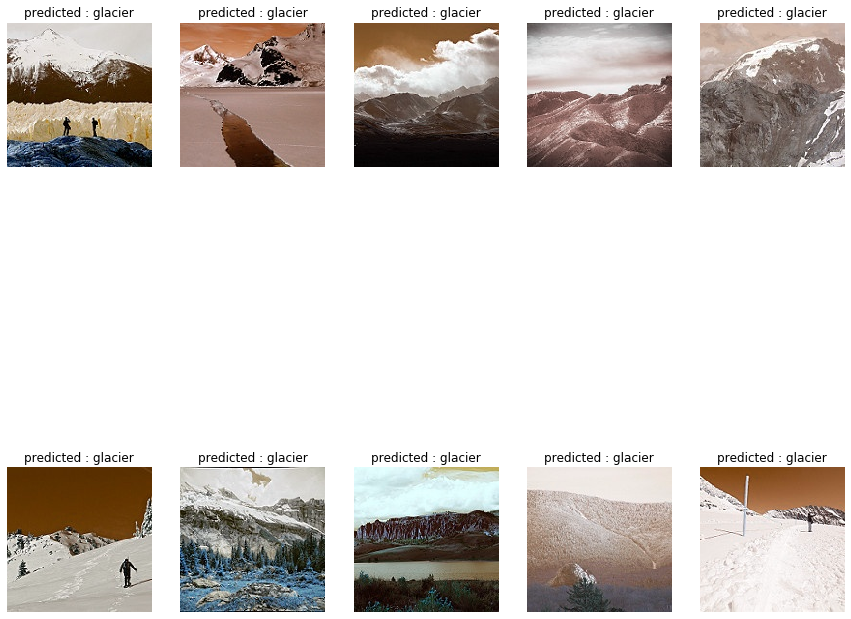

In [ ]:
#Images of mountains classified as glaciers
errors(y_pred,3,2,10)

Some of these images are hard to classify, even for a human.

However there are very few errors with the images of forests.

**A solution would be to train a One v One classifier to recognize a mountain from a glacier and a street from a building.**

## Trying a more powerful model

In [ ]:
train_data_path = 'seg_train'
test_data_path = 'seg_test'

size=(150,150)
epochs = 30
batch_size = 32
num_of_train_samples = 14000
num_of_test_samples = 3000

#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**This new model contains 6 convolutional layers, it will detect more complex patterns.**

In [ ]:
model = Sequential()

model.add(Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))

model.add(BatchNormalization())
model.add(Conv2D(200,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))

model.add(BatchNormalization())
model.add(Conv2D(150,kernel_size=(3,3),activation='relu'))

model.add(BatchNormalization())
model.add(Conv2D(150,kernel_size=(3,3),activation='relu'))

model.add(BatchNormalization())
model.add(Conv2D(100,kernel_size=(3,3),activation='relu'))

model.add(BatchNormalization())
model.add(Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))

model.add(Flatten())

model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(num_classes,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 200)     5600      
_________________________________________________________________
batch_normalization_3 (Batch (None, 148, 148, 200)     800       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 200)     360200    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 200)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 29, 200)       800       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 150)       270150    
_________________________________________________________________
batch_normalization_5 (Batch (None, 27, 27, 150)      

In [ ]:
training_1 = model.fit_generator(train_generator,
                                 steps_per_epoch=num_of_train_samples // batch_size,
                                 epochs=epochs,
                                 validation_data=validation_generator,
                                 validation_steps=num_of_test_samples // batch_size)

NameError: name 'model' is not defined

In [ ]:
plt.plot(training_1.history['acc'])
plt.plot(training_1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(training_1.history['loss'])
plt.plot(training_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

There is no obvious overfitting.

In [ ]:
validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)

Y_pred_1 = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred_1 = np.argmax(Y_pred_1, axis=1)

c=0
for i in range(len(validation_generator.classes)):
  if validation_generator.classes[i]==y_pred_1[i]:
    c+=1
    
print("Accuracy")
print(c/len(y_pred_1))

conf_mx_1=confusion_matrix(validation_generator.classes, y_pred_1)
print('Confusion Matrix')
print(conf_mx_1)

**There is an improvement from the previous model.**

In [ ]:
plot_confusion_matrix(conf_mx_1)

In [ ]:
row_sums_1 = conf_mx_1.sum(axis=1, keepdims=True)
norm_conf_mx_1 = conf_mx_1 / row_sums_1

np.fill_diagonal(norm_conf_mx_1, 0)

plot_confusion_matrix(norm_conf_mx_1)

There are still some errors between the previous problematic classes (0 vs 5 and 2 vs 3).

In [ ]:
errors(y_pred_1,2,3,10)

In [ ]:
errors(y_pred_1,5,0,10)

**This network has the same difficulties to distinguish those specific classes.**

**The results are way better.**

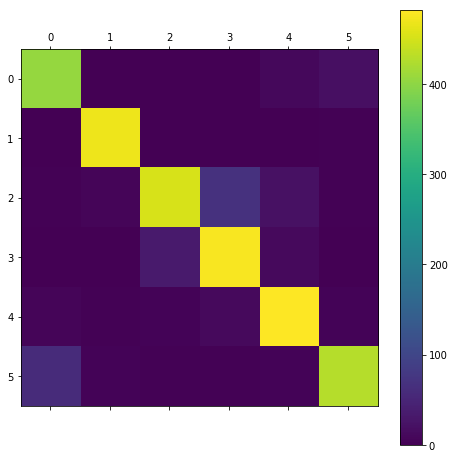

In [ ]:
plot_confusion_matrix(conf_mx_2)

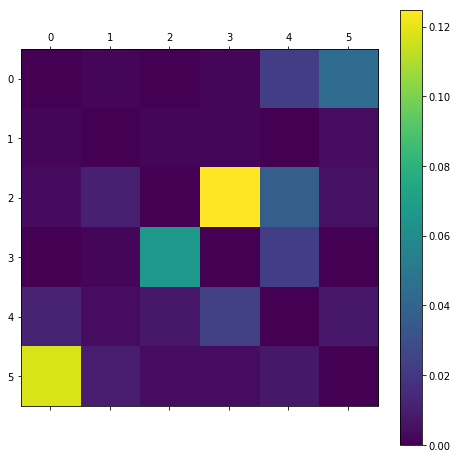

In [ ]:
row_sums_2 = conf_mx_2.sum(axis=1, keepdims=True)
norm_conf_mx_2 = conf_mx_2 / row_sums_2

np.fill_diagonal(norm_conf_mx_2, 0)

plot_confusion_matrix(norm_conf_mx_2)

**There are still some confusions between the buildings and the streets as well as between the glaciers and the mountains.**

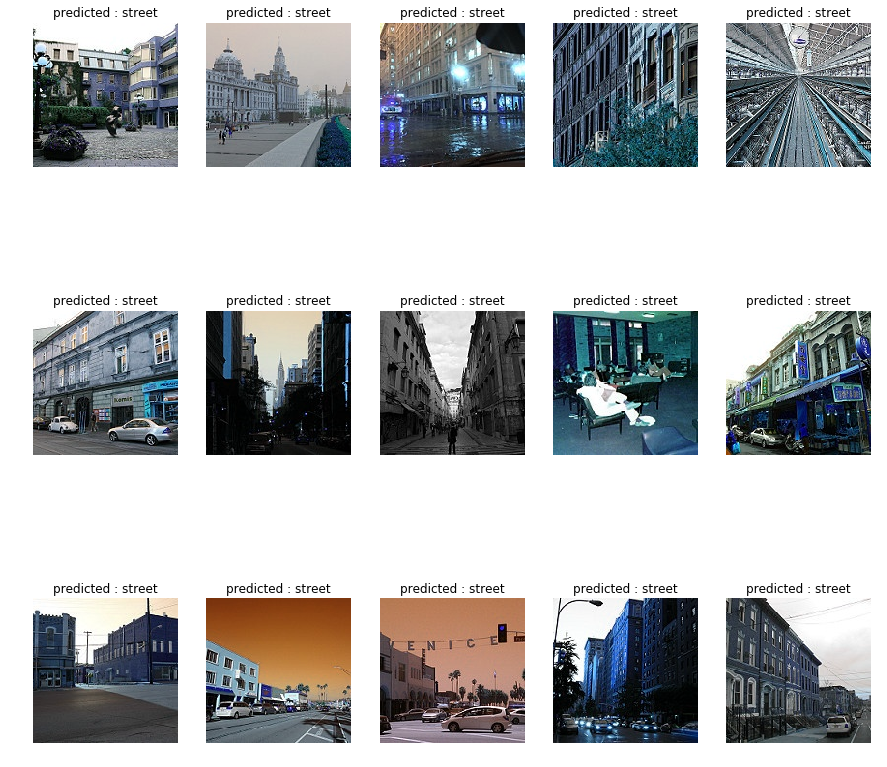

In [ ]:
errors(y_pred_2,0,5,15)

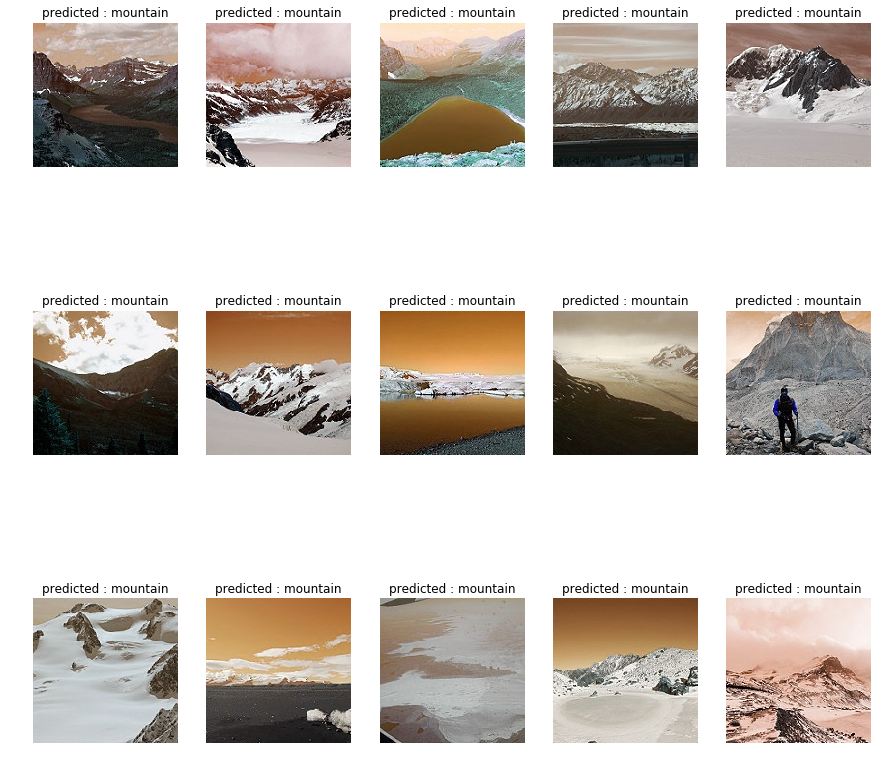

In [ ]:
errors(y_pred_2,2,3,15)

As you can see, most of the images wrongly classified are ambiguous. The images of buildings also present streets and the images of glaciers also have mountains.

**This ambiguity in the data makes it very hard to get better performances.**